# UV Dose: ASTM G222-21

The hourly PSM3 API endpoint provides modeled values of global horizontal ultraviolet light (GHUV) corresponding to two wavelength bands: 280–400 nm and 295–385 nm. This notebook shows that these values can be recreated precisely using the model defined in [ASTM G222-21](http://doi.org/10.1520/G0222-21).

In [1]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
VARIABLE_MAP = {
    'GHI': 'ghi',
    'Global Horizontal UV Irradiance (280-400nm)': 'ghuv-280-400',
    'Global Horizontal UV Irradiance (295-385nm)': 'ghuv-295-385',
    'Solar Zenith Angle': 'solar_zenith_angle',
}
df, meta = pvlib.iotools.get_psm3(40, -80, 'DEMO_KEY', 'assessingsolar@gmail.com',
                                  names=2020, interval=60,
                                  attributes=VARIABLE_MAP.values(),
                                  map_variables=False, leap_day=True)

df = df.rename(columns=VARIABLE_MAP)
df = df.iloc[:, 5:]

In [3]:
# "mean" coefficients (non-location-specific) from Table 1
m_280_400 = np.array([7.19e-2, -1.19e-2, 2.01e-3, -1.37e-4, 3.50e-6])
m_295_385 = np.array([5.70e-2, -9.70e-3, 1.54e-3, -9.51e-5, 2.10e-6])

def astm_g222_21(ghi, sza, mean_coeffs):
    am = 1 / (  # airmass model from REST (Gueymard 2003)
        pvlib.tools.cosd(sza) + 0.48353 * sza**0.09585 / (96.741 - sza)**1.754
    )
    am_powers = np.broadcast_to(am.values, (5, len(am))).T ** np.arange(5)
    ghuv = np.nansum(mean_coeffs * am_powers, axis=1) * ghi
    # the standard specifies how to calculate for zenith < 80, but
    # zenith > 80 is unspecified; in practice the PSM3 API returns zero:
    ghuv[sza > 80] = 0
    return ghuv

df['ghuv-280-400-predicted'] = astm_g222_21(df['ghi'], df['solar_zenith_angle'], m_280_400)
df['ghuv-295-385-predicted'] = astm_g222_21(df['ghi'], df['solar_zenith_angle'], m_295_385)

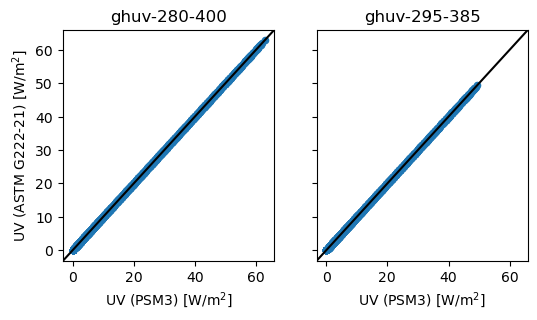

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 3))
for ax, col in zip(axes, ['ghuv-280-400', 'ghuv-295-385']):
    df.plot.scatter(col, col+'-predicted', ax=ax)
    ax.axline((0, 0), slope=1, c='k')
    ax.set_xlabel('UV (PSM3) [W/m$^2$]')
    ax.set_ylabel('UV (ASTM G222-21) [W/m$^2$]')
    ax.set_title(col)

In [5]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2023-02-14 09:10:14

numpy     : 1.23.4
matplotlib: 3.6.2
pvlib     : 0.9.3

